In [4]:

## Common functions etc
import re
import json
from calendar import isleap
from datetime import datetime, date, timedelta
from collections import defaultdict
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon, PathPatch, Patch, Rectangle, Circle
from matplotlib.path import Path
from matplotlib.colors import to_hex
from matplotlib.transforms import Bbox
import matplotlib.colors as colors
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from Bio import SeqIO
from matplotlib.colors import to_hex
import matplotlib.gridspec as gridspec
import csv
import numpy as np

plt.rcParams['figure.dpi'] = 150

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from dateutil.parser import parse
from collections import defaultdict, Counter
from dateutil import parser
import re

In [11]:
def parse_metadata(fname):
    with open(fname) as csvfile:
        print(f"Reading metadata {fname}...")
        reader = csv.DictReader(csvfile, delimiter="\t")
        meta = {row['name']: row for row in reader}
    return meta

def parse_alignment(fname, ref_name):
    """
    Returns the number of positions in each genome which match the reference
    """
    ref = None # ensure not shadowed
    for record in SeqIO.parse(open(fname,"r"), "fasta"):
        if record.name == ref_name:
            ref = record
            break
    if not ref:
        raise Exception("Ref not found")
    match_count = {}
    for record in SeqIO.parse(open(fname,"r"), "fasta"):
        match_count[record.name] = sum([ref.seq[i]==record.seq[i] for i in range(0, len(ref.seq))])
    return match_count

In [7]:
def colors(in_list, name='viridis'):
    rgb_array = mpl.colormaps[name].colors
    indexes = [int(np.floor(x)) for x in np.linspace(0, len(rgb_array)-1, len(in_list))]
    c = dict(zip(in_list, [rgb_array[i] for i in indexes]))
    c['None'] = [0.7, 0.7, 0.7]
    # c['Homo sapiens'] = [0.7, 0.7, 0.7]
    return c


Reading metadata ../ingest/results/v1/metadata.tsv...


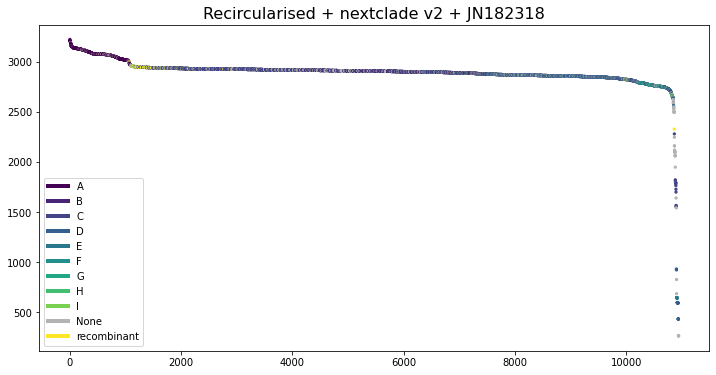

In [20]:
def plot_alignment_matches(title, metadata_fname, aln_fname, ref_name, radius=3, text=False, axlim=False, logfile=False):
    meta = parse_metadata(metadata_fname)
    match_count = parse_alignment(aln_fname, ref_name)

    data = [{'name': k, 'count': v} for k,v in match_count.items()]
    data.sort(key=lambda d:d['count'], reverse=True)
    for idx,d in enumerate(data):
        d['idx'] = idx
        d['genotype_genbank'] = meta[d['name']]['genotype_genbank']
        d['host'] = meta[d['name']]['host']

    color_by = 'genotype_genbank'
    c = colors(sorted([*set([d[color_by] for d in data])]))
    # print(c)


    fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(12, 6))
    ax.scatter([d['idx'] for d in data], [d['count'] for d in data],
               color=[c[d[color_by]] for d in data],
               marker='o', s=radius, alpha=1)
    
    if axlim:
        ax.set_xlim(left=0, right=axlim)
    # text labels?!?!?!
    if text:
        for d in data:
            ax.text(d['idx'], d['count'], s=f" {d['name']}", color='k', size=12, rotation=30) 
    
    ax.set_title(title, fontsize=16)
    
    ax.legend([Line2D([0], [0], color=color, lw=4) for color in c.values()], c.keys())

    plt.show()
    
    if logfile:
        with open(logfile, 'w') as fh:
            print("strain,alignmentMatch,alignmentMatchBin", file=fh)
            for d in data:
                if d['count']<1000:
                    category = "<1000"
                elif d['count']<1500:
                    category = "<1500"
                elif d['count']<2000:
                    category = "<2000"
                elif d['count']<2500:
                    category = "<2500"
                else:
                    category = ">2500"
                print(f"{d['name']},{d['count']},{category}", file=fh)

plot_alignment_matches("Recircularised + nextclade v2 + JN182318",
    '../ingest/results/v1/metadata.tsv', '../ingest/results/v1/nextclade.aligned.fasta', 'JN182318', 5, False)

Reading metadata ../ingest/results/genbank.tsv...


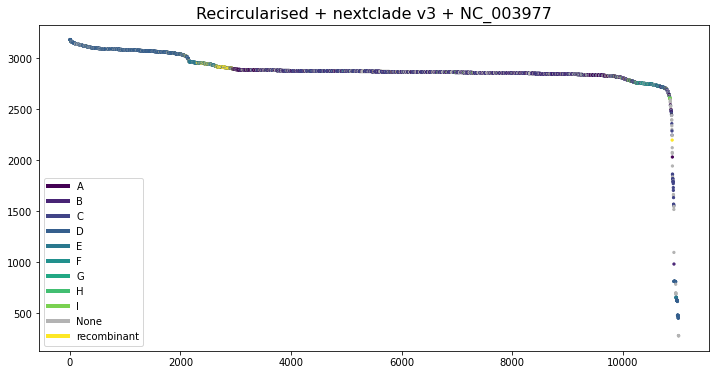

In [21]:
plot_alignment_matches("Recircularised + nextclade v3 + NC_003977",
    '../ingest/results/genbank.tsv', "../ingest/results/nextclade-using-recircularised.aligned.fasta", 'NC_003977', 5)

Reading metadata ../ingest/results/genbank.tsv...


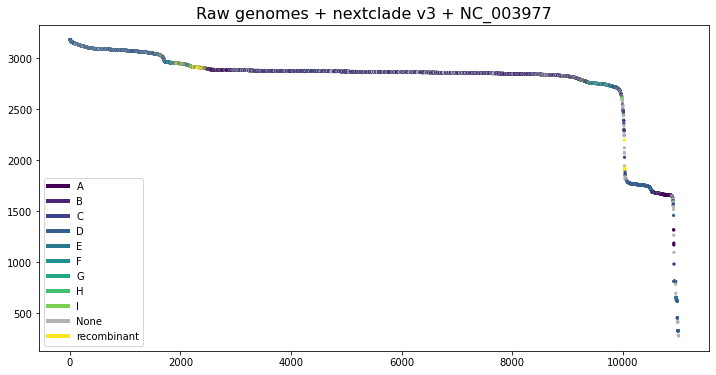

In [22]:
plot_alignment_matches("Raw genomes + nextclade v3 + NC_003977",
    '../ingest/results/genbank.tsv', "../ingest/results/nextclade-raw-genomes.aligned.fasta", 'NC_003977', 5)